### One-vs-Rest (OvR) Multinomial Logistic Regression

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd

# Load dataset with index and date parsing
lagged_1h_df = pd.read_csv("../data/athens_weather_df_2019_2023.csv", parse_dates=["date"])

In [3]:
import pickle

# Load the list of variables to transform
variables_to_transform_path = "../data/variables_to_transform.pkl"

with open(variables_to_transform_path, "rb") as f:
    variables_to_transform = pickle.load(f)

print(variables_to_transform)

['direct_radiation_lag_1h', 'cloud_cover_mid_lag_1h', 'cloud_cover_low_lag_1h', 'vapour_pressure_deficit_lag_1h', 'evapotranspiration_lag_1h']


Following the previous section where we applied an upsampling technique (SMOTE) to handle class imbalance and enhance the logistic regression model's performance, this time in the search for a possible improvement we will explore a more complex model.
This variant uses the One-vs-the-Rest (OvR) strategy.   
Also known as one-vs-all, this strategy involves fitting one classifier per class, where each class is fitted against all the other classes, effectively transforming the multiclass problem into multiple binary classification problems, which in the end will be combined again to construct the final multiclass model.   

By wrapping the `LogisticRegression` class inside the OvR strategy, we can build separate binary classifiers for each class and combine their predictions to perform multiclass classification. *(each binary classifier outputs a score (a probability) for its respective class, and the final prediction is made by selecting the class with the highest score(probability)).*   

While initially this seems unorthodox and naturally more computationally intensive, the goal of using this strategy is to reveal/identify patterns of the data at the binary level which might not be evident at the multi-class level and sometimes can enhance the model's ability to distinguish between classes.  
For more information, you can refer to the  **[official documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier

# Define features (X) and target (y)
X = lagged_1h_df.drop(columns=['date', 'weather_event'])
y = lagged_1h_df['weather_event']

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define the preprocessing step for Yeo-Johnson transformation
preprocessor = ColumnTransformer([
    ('yeo_johnson', PowerTransformer(method='yeo-johnson'), variables_to_transform),
], remainder='passthrough', force_int_remainder_cols=False)  # Leave other features untouched

# Define the pipeline
ovr_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Step 1: Yeo-Johnson transformation for specific variables
    ('scaling', RobustScaler()),       # Step 2: Scale all features
    ('ovr_model', OneVsRestClassifier(LogisticRegression(
        class_weight='balanced',
        max_iter=1500,
        random_state=42,
        solver='lbfgs',
        n_jobs=-1
    )))
])

# Fit the pipeline
import time
start = time.time()

ovr_pipeline.fit(X_train, y_train)

execution_time = time.time() - start
print(f"Execution time: {execution_time:.2f} seconds")

# Check the number of iterations for each classifier in the OneVsRest setup
for i, estimator in enumerate(ovr_pipeline['ovr_model'].estimators_):
    print(f"Class {i}: Number of iterations = {estimator.n_iter_}")

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('yeo_johnson',
                                                  PowerTransformer(),
                                                  ['direct_radiation_lag_1h',
                                                   'cloud_cover_mid_lag_1h',
                                                   'cloud_cover_low_lag_1h',
                                                   'vapour_pressure_deficit_lag_1h',
                                                   'evapotranspiration_lag_1h'])])),
                ('scaling', RobustScaler()),
                ('ovr_model',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  max_iter=1500,
                                                                  n_jobs=-1,
                                                                  random_state=42)))])

Execution time: 7.72 seconds
Class 0: Number of iterations = [46]
Class 1: Number of iterations = [45]
Class 2: Number of iterations = [31]


#### **Model Evaluation**

##### **CV evaluation**

In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

logreg_ovr_cv = cross_val_score(ovr_pipeline, X_train, y_train, cv=stkf, scoring="balanced_accuracy", n_jobs=-1)
print(logreg_ovr_cv)
print(f'\nThe mean value of balanced_accuracy is {logreg_ovr_cv.mean().round(3)}')
print(f'\nThe standard deviation of balanced_accuracy is {logreg_ovr_cv.std().round(3)}\n')

[0.83171213 0.91755485 0.92118704 0.92178101 0.91591901 0.91400861
 0.91576139 0.91801846 0.91114787 0.907155  ]

The mean value of balanced_accuracy is 0.907

The standard deviation of balanced_accuracy is 0.026



##### **The Confusion Matrix**

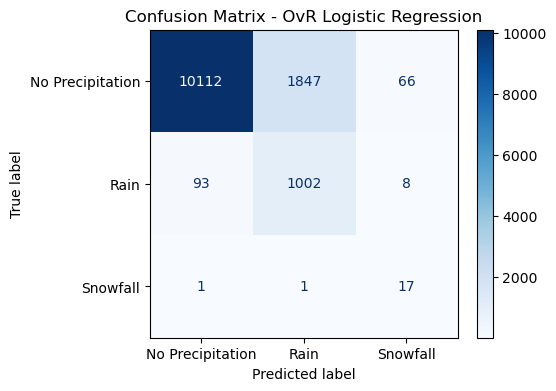

In [6]:
# Predict on the test set
y_pred_ovr = ovr_pipeline.predict(X_test)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix_ovr = confusion_matrix(y_test, y_pred_ovr)
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ovr, display_labels=['No Precipitation', 'Rain', 'Snowfall'])
plot = disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
title = plt.title('Confusion Matrix - OvR Logistic Regression')
plt.show()

- save the confusion matrix

In [7]:
from joblib import dump, load

# Define the file path
conf_matrix_path = "../reports/06_ovr_logistic_regression_confusion_matrix.joblib"

# Save the confusion matrix
dump(conf_matrix_ovr, conf_matrix_path)

print(f"OvR Logistic Regression confusion matrix saved at: {conf_matrix_path}")

['../reports/06_ovr_logistic_regression_confusion_matrix.joblib']

OvR Logistic Regression confusion matrix saved at: ../reports/06_ovr_logistic_regression_confusion_matrix.joblib


##### **The Precision-Recall Curve**

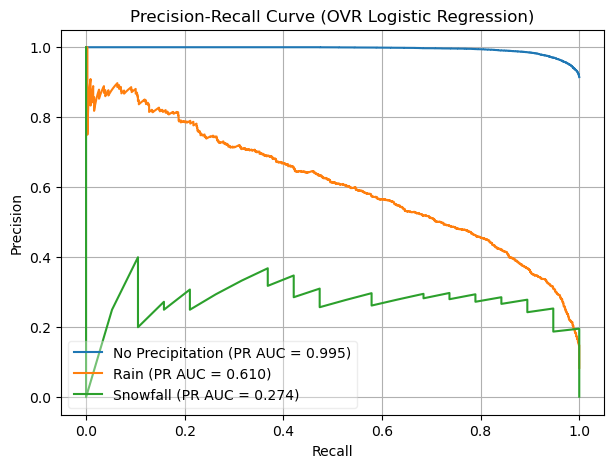

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Class labels
class_labels = ['No Precipitation', 'Rain', 'Snowfall']

# Producing the probabilities of each class for every data record in the test set
y_pred_probs_ovr = ovr_pipeline.predict_proba(X_test)

# Initialize plot
figure = plt.figure(figsize=(7, 5))  

# Loop through each class
for i, label in enumerate(class_labels):  
    precision, recall, _ = precision_recall_curve(y_test == i, y_pred_probs_ovr[:, i])
    pr_auc = auc(recall, precision)
    
    # Plot the precision-recall curve for the class
    pr_curve = plt.plot(recall, precision, label=f'{label} (PR AUC = {pr_auc:.3f})')

xlabel = plt.xlabel('Recall')
ylabel = plt.ylabel('Precision')
title = plt.title('Precision-Recall Curve (OVR Logistic Regression)')
legend = plt.legend(loc='lower left', framealpha=0.35)
grid = plt.grid(True)
plt.show()

##### **The Classification Report**

In [9]:

from sklearn.metrics import (
    classification_report, balanced_accuracy_score, f1_score, 
    average_precision_score, precision_recall_curve, auc
)
# Classification report
report_dict_ovr = classification_report(y_test, y_pred_ovr, digits=3, output_dict=True)

# Calculate PR AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_test == 0, y_pred_probs_ovr[:, 0])
pr_auc_0 = auc(recall_0, precision_0)

precision_rain, recall_rain, _ = precision_recall_curve(y_test == 1, y_pred_probs_ovr[:, 1])
pr_auc_rain = auc(recall_rain, precision_rain)

precision_snow, recall_snow, _ = precision_recall_curve(y_test == 2, y_pred_probs_ovr[:, 2])
pr_auc_snow = auc(recall_snow, precision_snow)

# Create a single row dataframe with the required metrics
report_df_ovr = pd.DataFrame({
    'precision_0': [report_dict_ovr['0']['precision']],
    'recall_0': [report_dict_ovr['0']['recall']],
    'f1_0': [report_dict_ovr['0']['f1-score']],
    'pr_auc_0': [pr_auc_0],
    
    'precision_rain': [report_dict_ovr['1']['precision']],
    'recall_rain': [report_dict_ovr['1']['recall']],
    'f1_rain': [report_dict_ovr['1']['f1-score']],
    'pr_auc_rain': [pr_auc_rain],
    
    'precision_snow': [report_dict_ovr['2']['precision']],
    'recall_snow': [report_dict_ovr['2']['recall']],
    'f1_snow': [report_dict_ovr['2']['f1-score']],
    'pr_auc_snow': [pr_auc_snow],
    'balanced_accuracy': [balanced_accuracy_score(y_test, y_pred_ovr)],
    'f1_macro': [f1_score(y_test, y_pred_ovr, average='macro')],
    'pr_auc_macro': [average_precision_score(y_test, y_pred_probs_ovr, average='macro')]

})

# Display the DataFrame
print('Logistic Regression with OVR')
report_df_ovr = report_df_ovr.round(4)
report_df_ovr

Logistic Regression with OVR


,precision_0,recall_0,f1_0,pr_auc_0,precision_rain,recall_rain,f1_rain,pr_auc_rain,precision_snow,recall_snow,f1_snow,pr_auc_snow,balanced_accuracy,f1_macro,pr_auc_macro
0,0.9908,0.8409,0.9097,0.9948,0.3516,0.9084,0.507,0.6098,0.1868,0.8947,0.3091,0.2745,0.8814,0.5753,0.634


- save the metrics report

In [10]:
# Define the file path
report_path = "../reports/06_ovr_logistic_regression_report.joblib"

# Save the report DataFrame
dump(report_df_ovr, report_path)

print(f"OvR Logistic Regression report saved at: {report_path}")

['../reports/06_ovr_logistic_regression_report.joblib']

OvR Logistic Regression report saved at: ../reports/06_ovr_logistic_regression_report.joblib


##### **The learning curve**

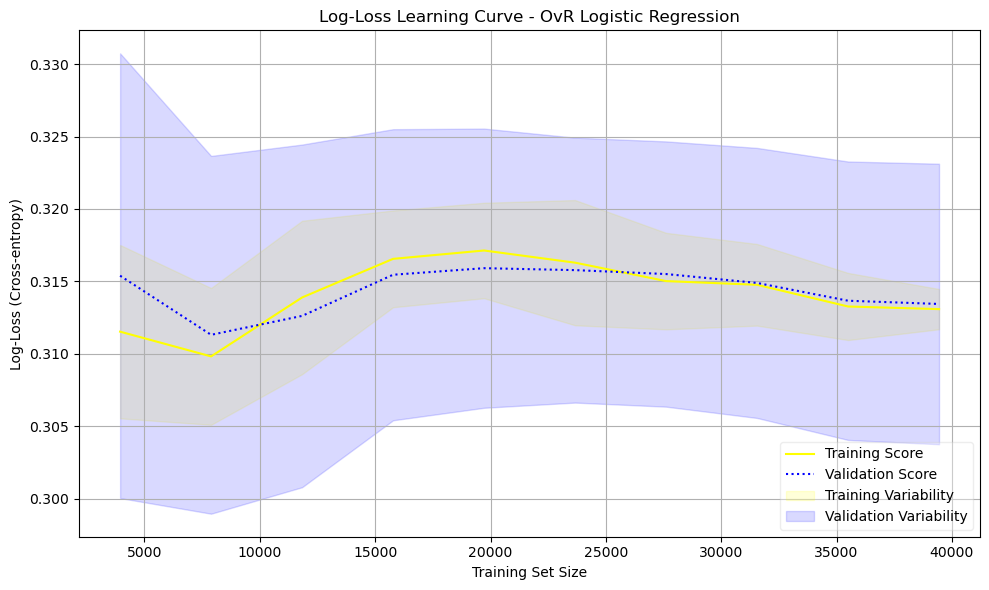

In [11]:
import numpy as np
from sklearn.model_selection import learning_curve
stkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    ovr_pipeline, X, y, cv=stkf, scoring='neg_log_loss', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

figure = plt.figure(figsize=(10, 6))
plot1 = plt.plot(train_sizes, train_mean, label='Training Score', color='yellow')
plot2 = plt.plot(train_sizes, test_mean, label='Validation Score', color='blue', linestyle=':')
ce1_fill = plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='yellow', 
                            alpha=0.15, label='Training Variability')
ce2_fill = plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='blue', 
                            alpha=0.15, label='Validation Variability')

xlabel = plt.xlabel('Training Set Size')
ylabel = plt.ylabel('Log-Loss (Cross-entropy)')
title = plt.title('Log-Loss Learning Curve - OvR Logistic Regression')
legend = plt.legend(loc='lower right', framealpha=0.35)
grid = plt.grid(True)
plt.tight_layout()
plt.show()

<u>Inferences from the Learning Curve Plot</u>   

The log-loss learning curve for the One-vs-Rest (OvR) logistic regression model shows that the training and validation log-loss curves are well-aligned, converging at approximately 0.314 when the full dataset is used. This indicates that the model does not appear to overfit or underfit and also as the dataset size increases the error on predictions appears to continue decreasing, but at a very slow rate.

Compared to the SMOTE-oversampled iteration, the log-loss remains in a similar range (- 0.314), however, the validation variance appears to be slightly lower, implying that the model's predictions are somewhat improved.

In conclusion the OvR Logistic Regression is benefiting from the binary classification approach across the multiple classes rather than forcing a single decision boundary for all classes at once (as in standard multinomial logistic regression).

**Save the Trained Model**

In [12]:
# Define the file path
model_path = "../models/ovr_logistic_regression.joblib"

# Save the entire pipeline
dump(ovr_pipeline, model_path)

print(f"OvR Logistic Regression model saved at: {model_path}")

['../models/ovr_logistic_regression.joblib']

OvR Logistic Regression model saved at: ../models/ovr_logistic_regression.joblib
